In [1]:
%%capture
!pip install transformers


Using the [Transformers library](https://huggingface.co/docs/transformers/index) by Hugging Face \
Inspiration [Venelin Valkov](https://www.youtube.com/c/VenelinValkovBG)

In [2]:

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Begginning

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Data/sentiment_analysis/top_reviews.csv", usecols=[4, 3])
df = df.rename(columns={'content': 'comment'})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


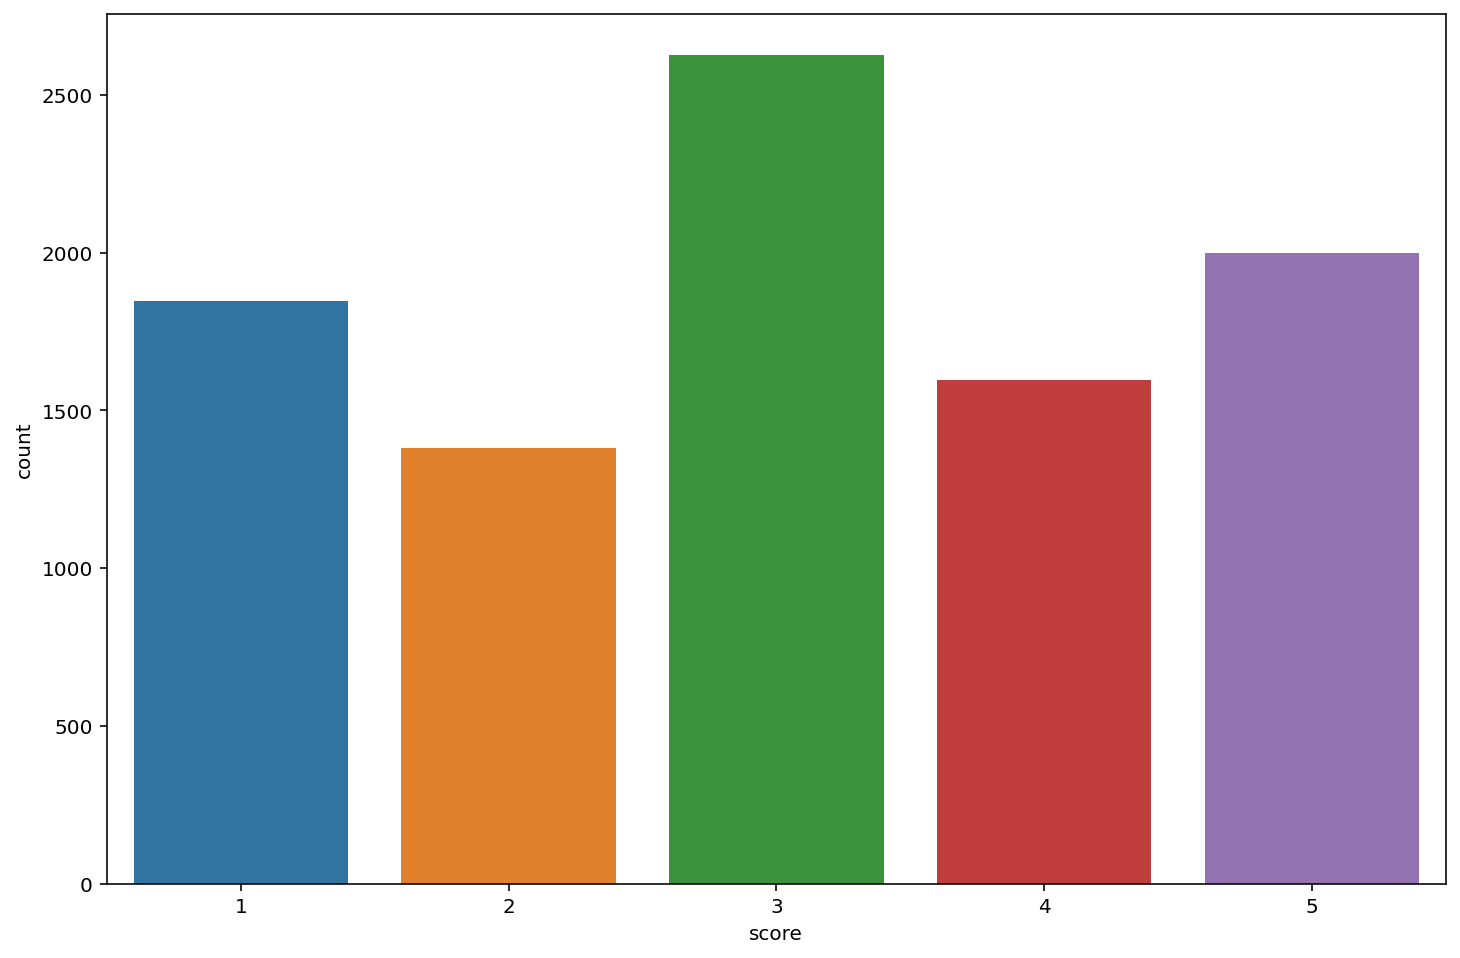

In [4]:
sns.countplot(df.score)

In [5]:
def to_sentiment(row):
  if row <= 2:
    return 0
  elif row == 3:
    return 1
  else:
    return 2
df.score = df.score.apply(to_sentiment)
class_names = df.score.unique()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


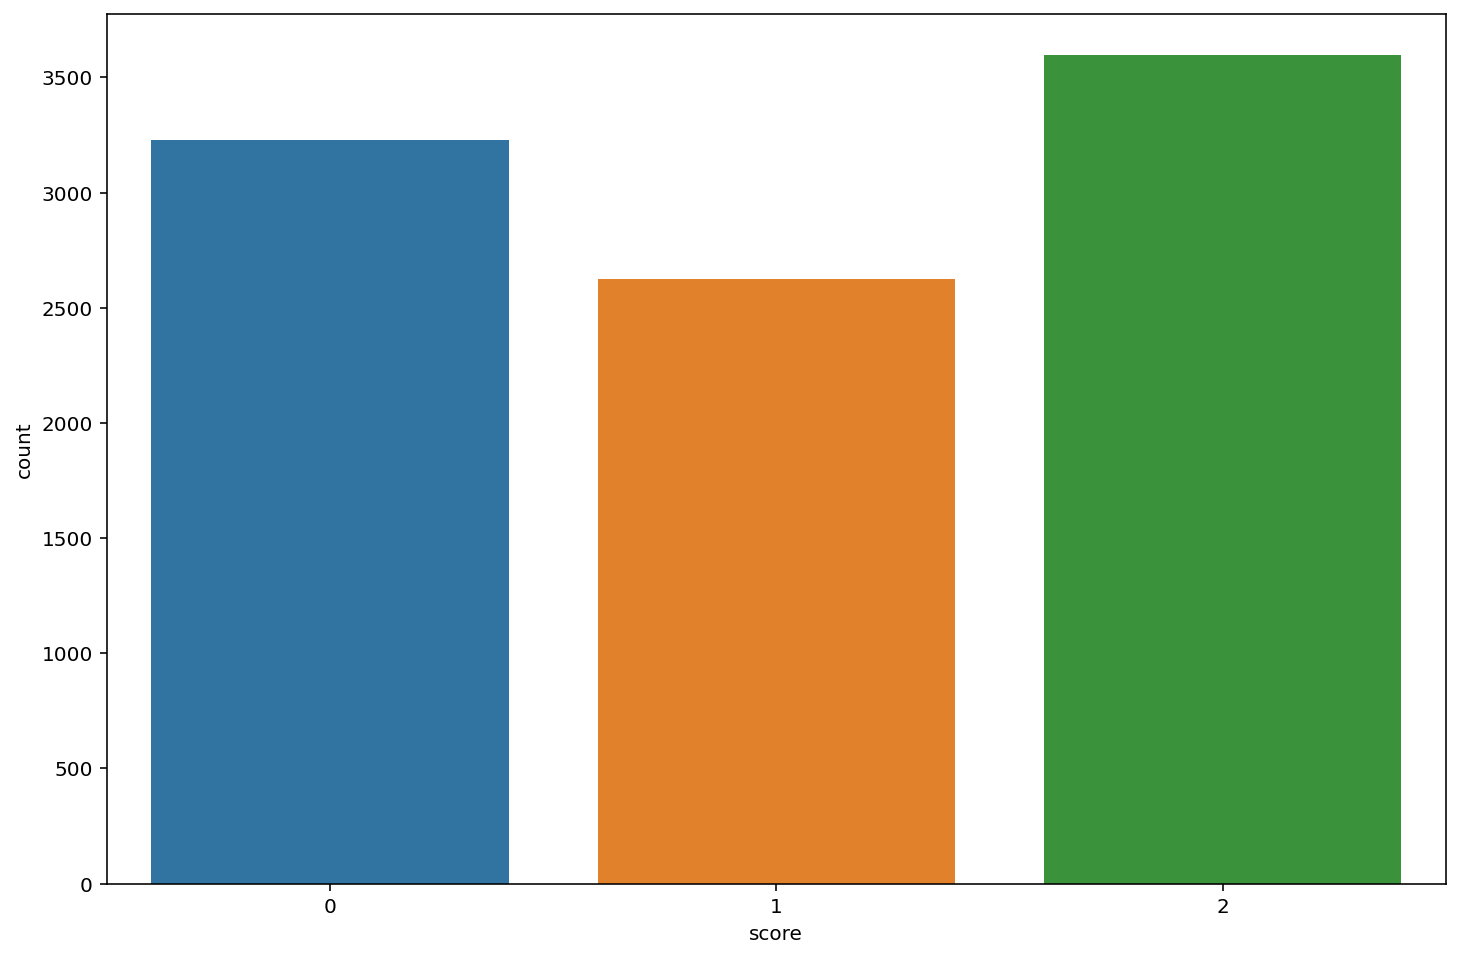

In [6]:
sns.countplot(df.score)

In [7]:
df.score.value_counts()

2    3596
0    3230
1    2626
Name: score, dtype: int64

In [8]:
class Config():
  MODEL_NAME = 'bert-base-cased'
  MAX_LEN = 160
  BATCH_SIZE = 8
  EPOCHES = 20  
  RANDOM_SEED = 17

## Data Preprocessing

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
""" Simple Exaple """
sample_txt = 'I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I am stuck at home for 2 weeks.
   Tokens: ['i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


 **Special Tokens**

BERT requires to have special tokens [SEP], [CLS] (to start each sentence) and [PAD], all this does method encode_plus

In [11]:
""" Simple Exaple """
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  padding=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
encoding['input_ids'] = encoding['input_ids'].to(torch.long)
encoding['attention_mask'] = encoding['attention_mask'].to(torch.long)

## Choosing Sequence Length

BERT works with fixed-length sequences. Use a simple strategy to choose the max length. Let’s store the token length of each review:



In [13]:
token_lens = []
for txt in df.comment:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


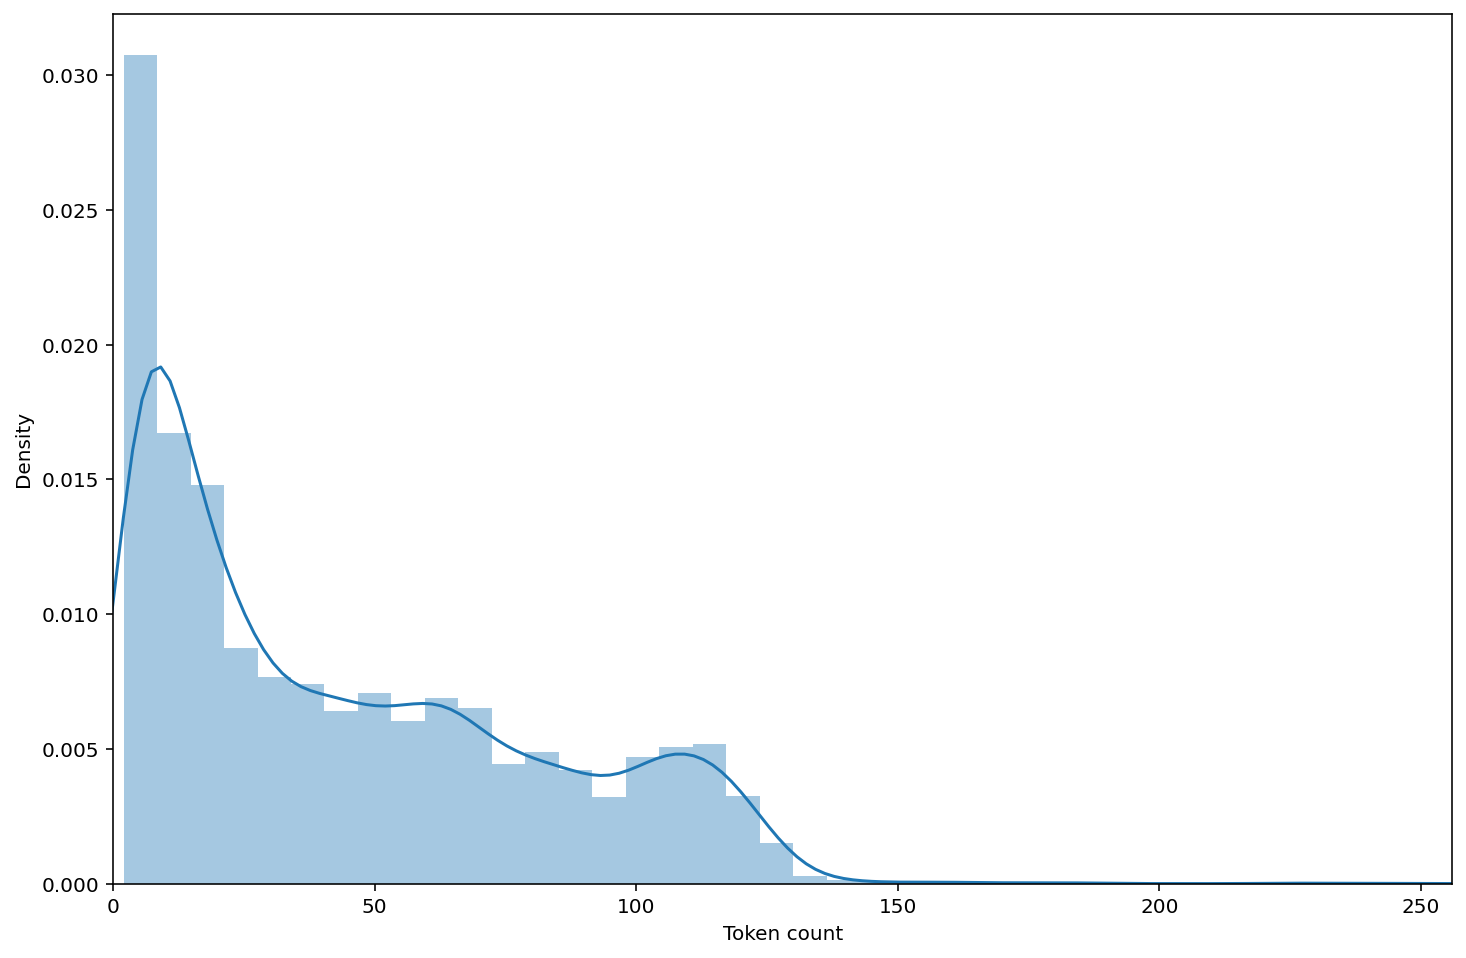

In [14]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');


All reviews less than 160

In [15]:
token_lens.sort()
print(token_lens[-20:])

[150, 154, 154, 158, 159, 159, 161, 164, 166, 174, 176, 176, 182, 183, 188, 224, 226, 234, 245, 322]


## Create DataSet

In [16]:
class GPReviewDataset(Dataset):
  def __init__(self, df, tokenizer, max_len):
    self.df = df
    self.reviews = df.comment.to_numpy()
    self.targets = df.score.to_numpy()
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'token_type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [17]:
df_train, df_test = train_test_split(
  df,
  test_size=0.15,
  random_state=Config.RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.3,
  random_state=Config.RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((8034, 2), (992, 2), (426, 2))

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    df,
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, Config.MAX_LEN, Config.BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, Config.MAX_LEN, Config.BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, Config.MAX_LEN, Config.BATCH_SIZE)

Check if everything works

In [19]:
""" Simple Exaple """
data = next(iter(train_data_loader))
data.keys()

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

torch.Size([8, 160])
torch.Size([8, 160])
torch.Size([8])


## Model

In [20]:
bert_model = BertModel.from_pretrained(Config.MODEL_NAME)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Try it to the sample sentence

In [21]:
print(encoding['input_ids'].size())
print(encoding['attention_mask'])
print(encoding['token_type_ids'])

torch.Size([1, 11])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [22]:
returns = bert_model(**encoding)
type(returns)

transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions

In [23]:
last_hidden_state, pooled_output = returns[0], returns[1]
print(f'Last Hidden State size {last_hidden_state.shape}')
print(f'Hidden Size {bert_model.config.hidden_size}')
print(f'Pooled_output shape {pooled_output.shape}')

Last Hidden State size torch.Size([1, 11, 768])
Hidden Size 768
Pooled_output shape torch.Size([1, 768])


In [24]:
class SentimentClassifier(nn.Module):

    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 3)
    
    def forward(self, input_ids, attention_mask):
        output = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask)
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [25]:
model = SentimentClassifier()
model = model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
""" Simple Example """
input_ids1 = data['input_ids'].to(device)
attention_mask1 = data['attention_mask'].to(device)
print(input_ids1.shape) # batch size x seq length
print(attention_mask1.shape)
out = F.softmax(model(input_ids1, attention_mask1), dim=1)
print(f'The result that modelk gives{out}')
_, preds = torch.max(out, dim=1)
print(f'Predictions that model gives {preds}')

torch.Size([8, 160])
torch.Size([8, 160])
The result that modelk givestensor([[0.3117, 0.4469, 0.2413],
        [0.4074, 0.3736, 0.2189],
        [0.3857, 0.4138, 0.2005],
        [0.2448, 0.5900, 0.1652],
        [0.3872, 0.4420, 0.1708],
        [0.4076, 0.3655, 0.2269],
        [0.4428, 0.3395, 0.2177],
        [0.2947, 0.4859, 0.2194]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predictions that model gives tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')


In [27]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [28]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def train_epoch_softmax(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

  
    predictions = torch.max(torch.nn.functional.softmax(outputs.logits, dim=-1), dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 100)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

**For 3 Epoches the result:**
\
** Validation accuracy is 0.7358 \
** Train Accuracy is 0.8356

# Evaluation

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [33]:
test_acc.item()

0.7464788732394366

In [34]:
model_path = 'model_sentiment_first.bin'
torch.save(model.state_dict(), model_path)

In [35]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [36]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       151
           1       0.58      0.64      0.61       118
           2       0.83      0.84      0.84       157

    accuracy                           0.75       426
   macro avg       0.74      0.74      0.74       426
weighted avg       0.75      0.75      0.75       426

